In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from pydrake.geometry.optimization import HPolyhedron
from pydrake.solvers import MosekSolver
from pydrake.trajectories import PiecewisePolynomial

from gcs.bezier import BezierGCS
from gcs.linear import LinearGCS
from gcs.rounding import *

import os
os.environ["MOSEKLM_LICENSE_FILE"] = "/Users/nolan/mosek/mosek.lic"
MosekSolver.AcquireLicense()
print("Mosek is enabled: ", MosekSolver().enabled())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mosek is enabled:  True


# Diamond Obstacle

source -> v1
v1 -> v3
v3 -> target


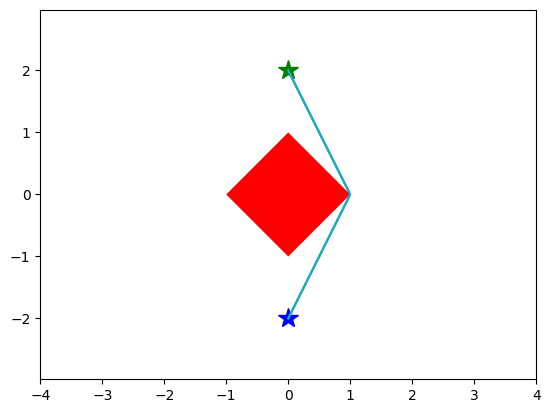

In [40]:
x_start = np.array([0., -2.])
x_goal = np.array([0., 2.])
convex_relaxation = True

A_bl = np.array([[-1, 0], [0, -1], [1, 1]])
A_br = np.array([[1, 0], [0, -1], [-1, 1]])
A_tl = np.array([[-1, 0], [0, 1], [1, -1]])
A_tr = np.array([[1, 0], [0, 1], [-1, -1]])
b = np.array([3, 3, -1])

regions = [
    HPolyhedron(A_bl, b),
    HPolyhedron(A_br, b),
    HPolyhedron(A_tl, b),
    HPolyhedron(A_tr, b),
]


plt.figure()
plt.plot(x_start[0], x_start[1], 'b*', markersize=15)
plt.plot(x_goal[0], x_goal[1], 'g*', markersize=15)
plt.fill([1, 0, -1, 0], [0, 1, 0, -1], 'r')
# ax[0].fill([1, 1, -1, -1], [-1, 1, 1, -1], 'r')
plt.axis('equal')
plt.gca().set_xlim(-4, 4)
plt.gca().set_ylim(-4, 4)

l_gcs = LinearGCS(regions)
l_gcs.addSourceTarget(x_start, x_goal)
l_gcs.setSolver(MosekSolver())
waypoints = l_gcs.SolvePath(convex_relaxation)[0]
t_knots = np.linspace(0, 1,  waypoints.shape[1])
lin_traj = PiecewisePolynomial.FirstOrderHold(t_knots, waypoints)

samples = np.linspace(lin_traj.start_time(), lin_traj.end_time())
values = np.squeeze([lin_traj.value(s) for s in samples])
plt.plot(values[:, 0], values[:, 1], "m-")

b_gcs = BezierGCS(regions, order=5, continuity=2)
b_gcs.addTimeCost(1)
b_gcs.addPathLengthCost(1)
b_gcs.addSourceTarget(x_start, x_goal)
b_gcs.setSolver(MosekSolver())
bezier_traj = b_gcs.SolvePath(convex_relaxation)[0]

samples = np.linspace(bezier_traj.start_time(), bezier_traj.end_time())
values = np.squeeze([bezier_traj.value(s) for s in samples])
plt.plot(values[:, 0], values[:, 1], "c-")

# Square Obstacle

In [ ]:
x_start = np.array([0., -2.])
x_goal = np.array([0., 2.])
convex_relaxation = True

regions = [
    HPolyhedron.MakeBox([-4, -4],[4, -1]), # Bottom
    HPolyhedron.MakeBox([-4, -4],[-1, 4]), # Left
    HPolyhedron.MakeBox([1, -4],[4, 4]),   # Right
    HPolyhedron.MakeBox([-4, 1],[4, 4]),   # Top
]


plt.figure()
plt.plot(x_start[0], x_start[1], 'b*', markersize=15)
plt.plot(x_goal[0], x_goal[1], 'g*', markersize=15)
plt.fill([1, 1, -1, -1], [-1, 1, 1, -1], 'r')
plt.axis('equal')
plt.gca().set_xlim(-4, 4)
plt.gca().set_ylim(-4, 4)

l_gcs = LinearGCS(regions)
l_gcs.addSourceTarget(x_start, x_goal)
l_gcs.setSolver(MosekSolver())
waypoints = l_gcs.SolvePath(convex_relaxation)[0]
t_knots = np.linspace(0, 1,  waypoints.shape[1])
lin_traj = PiecewisePolynomial.FirstOrderHold(t_knots, waypoints)

samples = np.linspace(lin_traj.start_time(), lin_traj.end_time())
values = np.squeeze([lin_traj.value(s) for s in samples])
plt.plot(values[:, 0], values[:, 1], "m-")

b_gcs = BezierGCS(regions, order=5, continuity=2)
b_gcs.addTimeCost(1)
b_gcs.addPathLengthCost(1)
b_gcs.addSourceTarget(x_start, x_goal)
b_gcs.setPaperSolverOptions()
b_gcs.setSolver(MosekSolver())
bezier_traj = b_gcs.SolvePath(convex_relaxation)[0]

samples = np.linspace(bezier_traj.start_time(), bezier_traj.end_time())
values = np.squeeze([bezier_traj.value(s) for s in samples])
plt.plot(values[:, 0], values[:, 1], "c-")

# Alternate rounding strategy
b_gcs = BezierGCS(regions, order=5, continuity=2)
b_gcs.addTimeCost(1)
b_gcs.addPathLengthCost(1)
b_gcs.addSourceTarget(x_start, x_goal)
b_gcs.setPaperSolverOptions()
b_gcs.setSolver(MosekSolver())
b_gcs.setRoundingStrategy([greedyForwardPathSearch, greedyBackwardPathSearch])
bezier_traj = b_gcs.SolvePath(convex_relaxation)[0]

samples = np.linspace(bezier_traj.start_time(), bezier_traj.end_time())
values = np.squeeze([bezier_traj.value(s) for s in samples])
plt.plot(values[:, 0], values[:, 1], "k-")